In [1]:
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from datetime import datetime
import xarray as xr
import iris
import cartopy.crs as ccrs
from iris.analysis.cartography import unrotate_pole, rotate_pole

# Test code for converting rotated grid 

In [2]:
date = '20201101T0000Z'
fdir = '/scratch/jk72/slf563/cylc-run/u-di850/share/cycle/{}/Regn1/resn_1/RAL3P2_glomap/um/'.format(date)
hour = '000'
fname = 'umnsaa_pa{}'.format(hour)

In [3]:
clon = 78
clat = -68.6

davis_lat = -68.5762
davis_lon = 77.9696

In [4]:
fixed_fields = iris.load(fdir+fname)

In [5]:
fixed_fields

[<iris 'Cube' of land_binary_mask / (1) (grid_latitude: 200; grid_longitude: 200)>,
<iris 'Cube' of surface_altitude / (m) (grid_latitude: 200; grid_longitude: 200)>]

In [6]:
clon = 78 #DAVIS
clat = -68.6
rotated_lons, rotated_lats = fixed_fields[0].coord('grid_longitude').points, fixed_fields[0].coord('grid_latitude').points
x, y = np.meshgrid(rotated_lons, rotated_lats)
#lons, lats = unrotate_pole(rotated_lons, rotated_lats, clon, clat+90) 
lons, lats = unrotate_pole(x, y, clon, clat+90)

In [7]:
fixed_fields_xr = xr.Dataset()

for i in range(0,len(fixed_fields)):
    fixed_fields_xr_tmp =  xr.DataArray.from_iris(fixed_fields[i]) 
    fixed_fields_xr = fixed_fields_xr.merge(fixed_fields_xr_tmp)

fixed_fields_xr = fixed_fields_xr.assign_coords({'latitude':(('grid_latitude','grid_longitude'),lats)})
fixed_fields_xr = fixed_fields_xr.assign_coords({'longitude':(('grid_latitude','grid_longitude'),lons)})


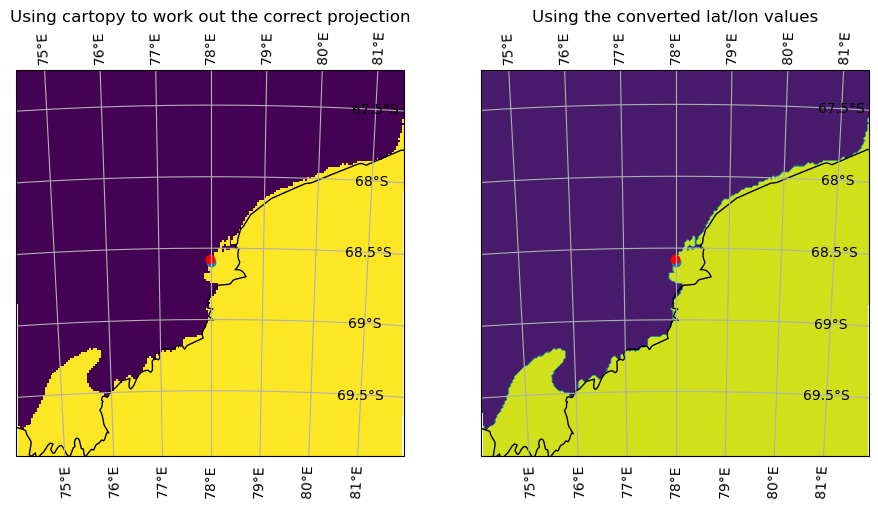

In [8]:
fig = plt.figure(figsize=(11,7))
ax = plt.subplot(121, projection=ccrs.SouthPolarStereo(central_longitude=clon))
                 
ax.coastlines();
ax.gridlines(draw_labels=True)

plt.plot(clon,clat,marker='o',linestyle='None',
         transform=ccrs.PlateCarree(),label='Central Point'); 

plt.plot(davis_lon,davis_lat,marker='o',linestyle='None',color='red',
         transform=ccrs.PlateCarree(),label='Davis'); 


proj=ccrs.RotatedPole(pole_latitude=clat+90, pole_longitude=clon,)
fixed_fields_xr['land_binary_mask'].plot(transform=proj,add_colorbar=False);
plt.title('Using cartopy to work out the correct projection')


ax = plt.subplot(122, projection=ccrs.SouthPolarStereo(central_longitude=clon))
                 
ax.coastlines();
ax.gridlines(draw_labels=True)

plt.plot(clon,clat,marker='o',linestyle='None',
         transform=ccrs.PlateCarree(),label='Central Point'); 

plt.plot(davis_lon,davis_lat,marker='o',linestyle='None',color='red',
         transform=ccrs.PlateCarree(),label='Davis'); 

proj=ccrs.PlateCarree()
plt.contourf(fixed_fields_xr['longitude'],fixed_fields_xr['latitude'],fixed_fields_xr['land_binary_mask'],transform=proj);
plt.title('Using the converted lat/lon values');

# Test on uneven grid size 

In [9]:
fname2 = 'umnsaa_pb{}'.format(hour)

In [10]:
surface_met = iris.load(fdir+fname2)

In [11]:
clon = 78 #DAVIS
clat = -68.6
rotated_lons, rotated_lats = surface_met[12].coord('grid_longitude').points, surface_met[12].coord('grid_latitude').points
x, y = np.meshgrid(rotated_lons, rotated_lats)
#lons, lats = unrotate_pole(rotated_lons, rotated_lats, clon, clat+90) 
lons, lats = unrotate_pole(x, y, clon, clat+90)

In [12]:
surface_met_xr =  xr.DataArray.from_iris(surface_met[12]) 
surface_met_xr = surface_met_xr.assign_coords({'latitude':(('grid_latitude','grid_longitude'),lats)})
surface_met_xr = surface_met_xr.assign_coords({'longitude':(('grid_latitude','grid_longitude'),lons)})

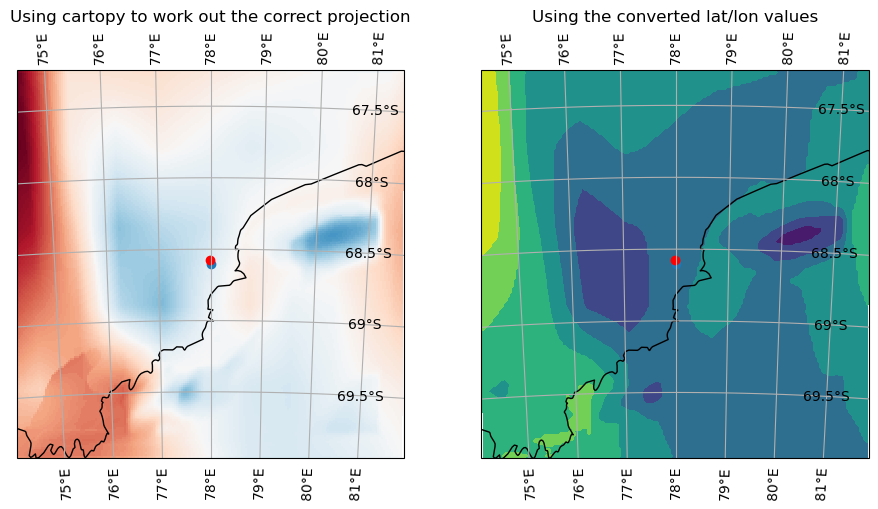

In [13]:
fig = plt.figure(figsize=(11,7))
ax = plt.subplot(121, projection=ccrs.SouthPolarStereo(central_longitude=clon))
                 
ax.coastlines();
ax.gridlines(draw_labels=True)

plt.plot(clon,clat,marker='o',linestyle='None',
         transform=ccrs.PlateCarree(),label='Central Point'); 

plt.plot(davis_lon,davis_lat,marker='o',linestyle='None',color='red',
         transform=ccrs.PlateCarree(),label='Davis'); 


proj=ccrs.RotatedPole(pole_latitude=clat+90, pole_longitude=clon,)
surface_met_xr[0,:,:].plot(transform=proj,add_colorbar=False);
plt.title('Using cartopy to work out the correct projection')


ax = plt.subplot(122, projection=ccrs.SouthPolarStereo(central_longitude=clon))
                 
ax.coastlines();
ax.gridlines(draw_labels=True)

plt.plot(clon,clat,marker='o',linestyle='None',
         transform=ccrs.PlateCarree(),label='Central Point'); 

plt.plot(davis_lon,davis_lat,marker='o',linestyle='None',color='red',
         transform=ccrs.PlateCarree(),label='Davis'); 

proj=ccrs.PlateCarree()
plt.contourf(surface_met_xr['longitude'],surface_met_xr['latitude'],surface_met_xr[0,:,:],transform=proj);
plt.title('Using the converted lat/lon values');

# Function to pull out exact location of a point: 

In [14]:
def filter_exact_lat_lon(data,lat_point,lon_point,central_lat,central_lon): 
    grid_lon, grid_lat = rotate_pole(np.array(lon_point), np.array(lat_point), central_lon, central_lat+90)
    point_data = data.sel(grid_latitude = grid_lat, grid_longitude=grid_lon, method='nearest')
    return point_data

In [15]:
fixed_fields_davis = filter_exact_lat_lon(fixed_fields_xr,davis_lat,davis_lon,clat,clon)
surface_met_davis = filter_exact_lat_lon(surface_met_xr,davis_lat,davis_lon,clat,clon)

In [16]:
fixed_fields_davis['surface_altitude']

<xarray.DataArray 'surface_altitude' (grid_latitude: 1, grid_longitude: 1)>
dask.array<getitem, shape=(1, 1), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * grid_latitude            (grid_latitude) float32 0.027
  * grid_longitude           (grid_longitude) float32 180.0
    forecast_period          timedelta64[ns] 00:00:00
    forecast_reference_time  datetime64[ns] 2020-11-01
    time                     datetime64[ns] 2020-11-01
    latitude                 (grid_latitude, grid_longitude) float64 -68.57
    longitude                (grid_latitude, grid_longitude) float64 77.96
Attributes:
    standard_name:  surface_altitude
    units:          m
    source:         Data from Met Office Unified Model
    um_version:     13.0
    STASH:          m01s00i033

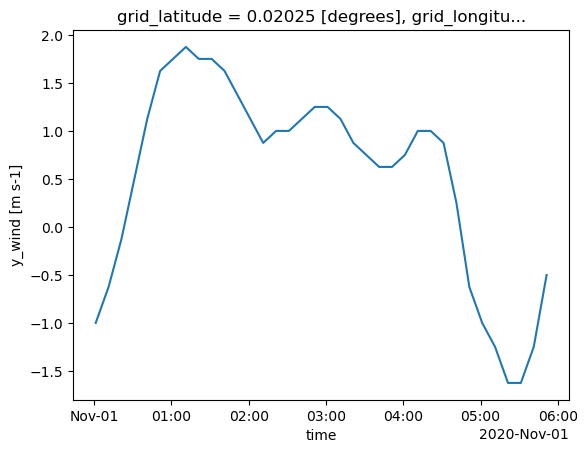

In [17]:
surface_met_davis.plot()

In [18]:
surface_met_davis.assign_attrs({'Latitude':lat_point,'Longitude':lon_point})

NameError: name 'lat_point' is not defined